In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [55]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import desc
from sqlalchemy.ext.automap import automap_base 
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
Measurementcolumns = inspector.get_columns('measurement')
for c in Measurementcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and ty
Stationcolumns = inspector.get_columns('station')
for c in Stationcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


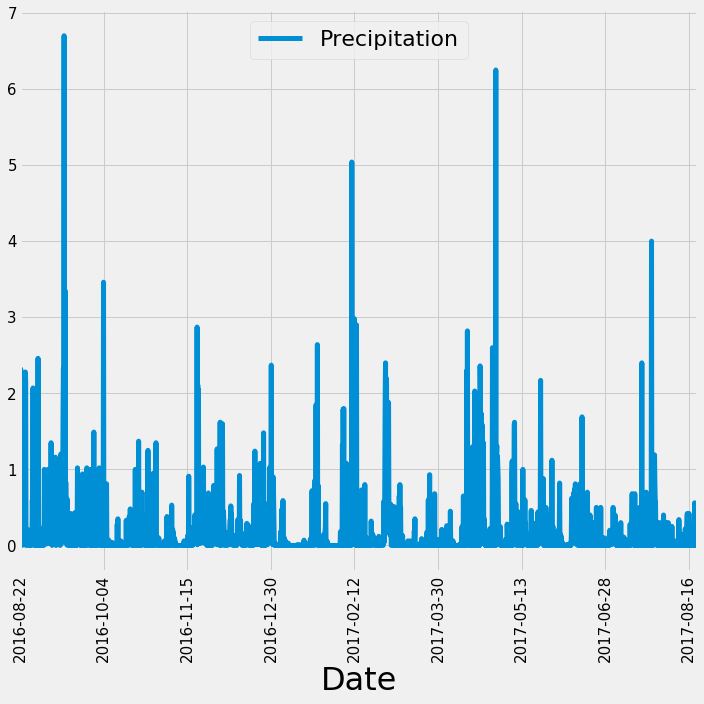

In [147]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipit = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between('2016-08-22', '2017-08-23')).all()

df = pd.DataFrame(precipit).sort_values('date', ascending = True).dropna()

# This way is also correct but it doesnt work well for some reason. Seems that indexing by date doesnt do the job.
# precipitation= []
# for result in precipit:
#     row = {"Date":"Precipitation"}
#     row["Date"] = result[0]
#     row["Precipitation"] = result[1]
#     precipitation.append(row)
# df = pd.DataFrame(precipitation)
# df = df.set_index('Date')
# dr = df.sort_values('Date', ascending = True)
# df = df.dropna()

df.plot('date', 'prcp', linewidth=5, figsize=(10,10), fontsize=15)
plt.xlabel("Date", fontsize=32)
plt.legend(["Precipitation"], loc="upper center", fontsize=22)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_data = session.query(Station.station).all()
station_data = pd.DataFrame(station_data)
station_data.count()

station    9
dtype: int64

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active = session.query(Measurement.station,Measurement.date, Measurement.prcp, Measurement.tobs ).all()
active = pd.DataFrame(active)
result = active.groupby('station').nunique()
result = result.sort_values('date', ascending=False)
result = result.drop(columns={'station'})
result.rename(columns={'date': 'Number_of_Stations'})


,Number_of_Stations,prcp,tobs
station,,,
USC00519281,2772,194,31
USC00519397,2724,98,30
USC00513117,2709,149,27
USC00519523,2669,140,30
USC00516128,2612,260,27
USC00514830,2202,115,26
USC00511918,1979,77,34
USC00517948,1372,51,28
USC00518838,511,76,25


In [148]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = 'USC00519281'

statsmf = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
                        func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

table = pd.DataFrame({'Min Temp':statsmf[0][0],'Max Temp':statsmf[0][1], "Avg": statsmf[0][2]},index=[0])
table



,Min Temp,Max Temp,Avg
0,54.0,85.0,71.663781


In [149]:
# Choose the station with the highest number of temperature observations.
highfreq = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highfreq= highfreq[0]
highfreq

'USC00519281'

In [ ]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query( Measurement.tobs).filter(Measurement.date >= str(one_year_back)).filter(Measurement.station == most_tobs_station).all()
tobs_data_df = pd.DataFrame(tobs_data)


In [94]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
target_tobs = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == highfreq).all()
target_tobs = pd.DataFrame(target_tobs)
#target_tobs


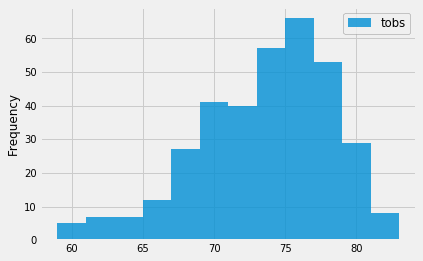

In [93]:
# Histogram
# extract only the tobs data from the DF
chartobs = target_tobs['tobs']
chartobs
#build histogram
num_bins = 12
plt.hist(chartobs, num_bins, label = 'tobs',alpha=0.8)
plt.ylabel('Frequency', fontsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)
legend = plt.legend(frameon=True, edgecolor='grey', fontsize='small')
plt.show()

In [ ]:
#BONUS HOMEWORK

In [150]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [160]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
triptemp = calc_temps('2016-08-22', '2017-08-23')
triptemp

[(58.0, 74.59901654000895, 87.0)]

In [180]:
# Plot the results from your previous query as a bar chart.
triptemp_df = pd.DataFrame(triptemp, columns=["Min","Ave","Max"])
triptemp_df

,Min,Ave,Max
0,58.0,74.599017,87.0


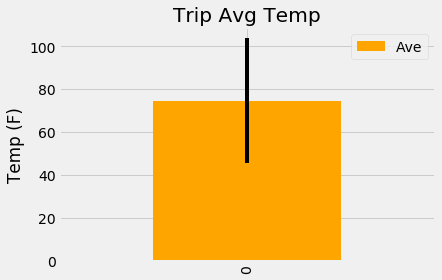

In [191]:
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

triptemp_df.plot.bar(y='Ave', yerr=(triptemp_df['Max']-triptemp_df['Min']),title='Trip Avg Temp', color='orange')
plt.ylabel("Temp (F)")
plt.show()

In [202]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
bonus = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-08-22').\
    filter(Measurement.date <= '2017-08-23').\
    group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(bonus)


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]
